In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastai.vision import *
import torch

from mrnet_orig import *

%matplotlib inline

In [2]:
! tree -d ..

..
├── data
│   ├── axial
│   │   ├── train
│   │   └── valid
│   ├── coronal
│   │   ├── train
│   │   └── valid
│   └── sagittal
│       ├── models
│       ├── train
│       └── valid
└── mrnet-fastai
    ├── exp
    └── __pycache__

14 directories


In [3]:
! ls

df_abnl.pkl  loss_weights.pt		 mrnet_orig.py	slice_stats.json
exp	     MRNet_EDA.ipynb		 __pycache__	train_cases.pkl
LICENSE      MRNet_fastai_example.ipynb  README.md	train_pix_distr.pkl


In [4]:
! ls ../data

axial	  train-abnormal.csv  valid-abnormal.csv
coronal   train-acl.csv       valid-acl.csv
sagittal  train-meniscus.csv  valid-meniscus.csv


In [5]:
data_path = Path('../data')
sag_path = data_path/'sagittal'
cor_path = data_path/'coronal'
ax_path = data_path/'axial'

## Substantial class imbalance for the normal/abnormal task

Given this, we'll derive weights for a weighted binary cross entropy loss function.

In [6]:
train_abnl = pd.read_csv(data_path/'train-abnormal.csv', header=None,
                       names=['Case', 'Abnormal'], 
                       dtype={'Case': str, 'Abnormal': np.int64})
print(train_abnl.shape)
train_abnl.head()

(1130, 2)


,Case,Abnormal
0,0000,1
1,0001,1
2,0002,1
3,0003,1
4,0004,1


In [7]:
w = train_abnl.Abnormal.sum() / train_abnl.shape[0]
print(w)
weights = Tensor([w, 1-w])
print(weights)
torch.save(weights, 'loss_weights.pt')

0.8079646017699115
tensor([0.8080, 0.1920])


In [8]:
weights = torch.load('loss_weights.pt')

## Load previously created files

- `df_abnl` -> master `df` for use with Data Block API, also contains # of slices per series
- `slice_stats` -> `dict` stored as `json` with mean and max # of slices per series

In [9]:
df_abnl = pd.read_pickle('df_abnl.pkl')
df_abnl.head()

,Case,Abnormal,is_valid,coronal_slices,sagittal_slices,axial_slices
0,train/0000,1,0,25,27,25
1,train/0001,1,0,22,23,28
2,train/0002,1,0,24,24,24
3,train/0003,1,0,22,21,25
4,train/0004,1,0,30,30,31


In [10]:
with open('slice_stats.json', 'r') as file:
    stats = json.load(file)
    
stats

{'coronal': {'mean': 29.6416, 'max': 57},
 'sagittal': {'mean': 30.3776, 'max': 51},
 'axial': {'mean': 34.2032, 'max': 61}}

In [11]:
max_slc = stats['sagittal']['max']
print(max_slc)

51


## MRNet implementation

Modified from the original [paper](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002699) to (sort of) work with `fastai`

In [12]:
il = MR3DImageList.from_df(df_abnl, sag_path, suffix='.npy')

In [13]:
il.items[0]

'../data/sagittal/train/0000.npy'

In [14]:
il

MR3DImageList (1250 items)
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
Path: ../data/sagittal

In [15]:
sd = il.split_from_df(col=2)
sd

ItemLists;

Train: MR3DImageList (1130 items)
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
Path: ../data/sagittal;

Valid: MR3DImageList (120 items)
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
Path: ../data/sagittal;

Test: None

In [16]:
ll = sd.label_from_df(cols=1)
ll

LabelLists;

Train: LabelList (1130 items)
x: MR3DImageList
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
y: CategoryList
1,1,1,1,1
Path: ../data/sagittal;

Valid: LabelList (120 items)
x: MR3DImageList
Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256),Image (51, 3, 256, 256)
y: CategoryList
0,0,0,0,0
Path: ../data/sagittal;

Test: None

In [17]:
# tfms = get_transforms()

In [18]:
bs = 1
data = ll.databunch(bs=bs)

In [19]:
learn = mrnet_learner(data, MRNet(), opt_func=optim.Adam, loss_func=WtBCELoss(weights),
                      callbacks=MRNetCallback(), metrics=accuracy)

In [20]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 63, 63]         23,296     False     
______________________________________________________________________
ReLU                 [64, 63, 63]         0          False     
______________________________________________________________________
MaxPool2d            [64, 31, 31]         0          False     
______________________________________________________________________
Conv2d               [192, 31, 31]        307,392    False     
______________________________________________________________________
ReLU                 [192, 31, 31]        0          False     
______________________________________________________________________
MaxPool2d            [192, 15, 15]        0          False     
______________________________________________________________________
Conv2d               [384, 15, 15]        663,936    False     
______________________________________________________________

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


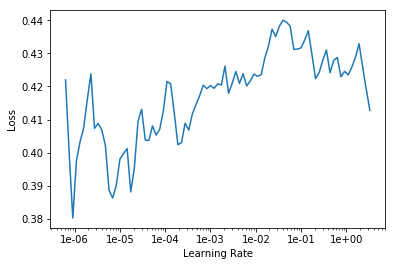

In [22]:
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(1, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.443489,0.453011,0.208333,08:15


Accuracy is terrible, but what do you expect out of a single linear layer...?

In [24]:
learn.unfreeze()

In [25]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 63, 63]         23,296     True      
______________________________________________________________________
ReLU                 [64, 63, 63]         0          False     
______________________________________________________________________
MaxPool2d            [64, 31, 31]         0          False     
______________________________________________________________________
Conv2d               [192, 31, 31]        307,392    True      
______________________________________________________________________
ReLU                 [192, 31, 31]        0          False     
______________________________________________________________________
MaxPool2d            [192, 15, 15]        0          False     
______________________________________________________________________
Conv2d               [384, 15, 15]        663,936    True      
______________________________________________________________